In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from matplotlib import cm

import os,sys,glob,numpy as np, pandas as pd

from skimage import measure

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from nilearn.image import index_img

from dipy.core.gradients import gradient_table
from dipy.reconst import shm
from dipy.direction import peaks

from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.io.dpy import Dpy


import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from dipy.tracking.distances import approx_polygon_track

In [2]:
def convert_simnibs_fsavg_to_cifti_32K(in_file,run_it=False):#,base_dir=False):
    
    hcp_pipelines_dir = '/nethome/kcni/hharita/Code/HCPpipelines'
    surf_dir = hcp_pipelines_dir + '/global/templates/standard_mesh_atlases/resample_fsaverage'
    #in_dat = nib.freesurfer.read_morph_data(in_file)
   
    #in_gii = base_dir + '/' + in_file + '_164k.gii'
    in_gii = in_file + '_164k.gii'
    cmd1 = 'mri_convert %s %s' %(in_file,in_gii)
    
    out_gii = in_gii.replace('_164k.gii', '_cifti32k.gii')
    #cmdstr = 'wb_command -metric-resample test_gii.gii fsaverage_std_sphere.L.164k_fsavg_L.surf.gii fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii ADAP_BARY_AREA test_gii_32K.gii -area-metrics fsaverage.L.midthickness_va_avg.164k_fsavg_L.shape.gii fs_LR.L.midthickness_va_avg.32k_fs_LR.shape.gii

    f1 = in_gii
       
    #cmdstr = 'wb_command -metric-resample test_gii.gii
    f2 = surf_dir + '/fsaverage_std_sphere.L.164k_fsavg_L.surf.gii'
    f3 = surf_dir + '/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii'
    f4 = out_gii
    f5 = surf_dir + '/fsaverage.L.midthickness_va_avg.164k_fsavg_L.shape.gii'
    f6 = surf_dir + '/fs_LR.L.midthickness_va_avg.32k_fs_LR.shape.gii'
   
    cmd2str = 'wb_command -metric-resample %s %s %s ADAP_BARY_AREA %s -area-metrics %s %s'

   
    cmd2 = cmd2str %(f1,f2,f3,f4,f5,f6)
   
    if run_it:
        print('\n\nconverting input file to .gii\n')
        print(cmd1)
        
        #! $cmd1
        #os.system(cmd1)
        
        print('\n\nconverting .gii file to cifti 32k space\n')
        print(cmd2)
        #! $cmd2
        #os.system(cmd1)
        #os.system(cmd2)
       
       
    return cmd1,cmd2,out_gii



### Load in surface files ...

In [3]:
# Directory

data_direc = '/nethome/kcni/hharita/Data/HCP_WB_Tutorial_TEST/HCP_WB_Tutorial_1.0'

# Left Hemisphere MID-THICKNESS Surface file
mtleft_file = data_direc + '/Q1-Q6_R440.L.midthickness.32k_fs_LR.surf.gii'

# Left Hemisphere INFLATED Surface file
infleft_file = data_direc + '/Q1-Q6_R440.L.inflated.32k_fs_LR.surf.gii'

# Left Hemisphere VERY INFLATED Surface file 

vinfleft_file = data_direc + '/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'

# Left Hemisphere PIAL Surface file
pialleft_file = data_direc + '/Q1-Q6_R440.L.pial.32k_fs_LR.surf.gii'

# Left Hemisphere FLAT Surface file

flatleft_file = data_direc + '/Q1-Q6_R440.L.flat.32k_fs_LR.surf.gii'

# curved surface 

curv_file = data_direc + '/Q1-Q6_R440.All.curvature.32k_fs_LR.dscalar.nii'

# sulcus file

sulc_file = data_direc + '/Q1-Q6_R440.All.sulc.32k_fs_LR.dscalar.nii'

# Left hemisphere SPHERICAL surface file

sphere_file = data_direc + '/Q1-Q6_R440.L.sphere.32k_fs_LR.surf.gii'

# for the cifti-2 converted label file

anotherdir = '/external/rprshnas01/kcni/hharita/Data/HCP_WB_Tutorial_TEST/HCP_WB_Tutorial_1.0'
label_file = anotherdir + '/parcellations_VGD11b.32k_fs_LR_c2.dlabel.nii'

# Left Hemisphere PIAL Surface file
pialright_file = data_direc + '/Q1-Q6_R440.R.pial.32k_fs_LR.surf.gii'

In [4]:
# read in the loaded surfaces ...

# Mid-thickness surface
img_mt = nib.load(mtleft_file) 
mt_vtx = img_mt.darrays[0].data
mt_tri = img_mt.darrays[1].data

# Pial surface
img_pial = nib.load(pialleft_file)
pial_vtx = img_pial.darrays[0].data
pial_tri = img_pial.darrays[1].data

# Inflated surface
img_inf = nib.load(infleft_file)
inf_vtx = img_inf.darrays[0].data
inf_tri = img_inf.darrays[1].data

# Inflated surface
img_vinf = nib.load(vinfleft_file)
vinf_vtx = img_vinf.darrays[0].data
vinf_tri = img_vinf.darrays[1].data

# Flat surface 

img_flat = nib.load(flatleft_file)
flat_vtx = img_flat.darrays[0].data
flat_tri = img_flat.darrays[1].data

# Spherical surface

img_sphere = nib.load(sphere_file)
sphere_vtx = img_sphere.darrays[0].data
sphere_tri = img_sphere.darrays[1].data

In [5]:
# mid-thickness
df_mt_vtx = pd.DataFrame(mt_vtx, columns=['x','y','z'])

# pial
df_pial_vtx = pd.DataFrame(pial_vtx, columns=['x','y','z'])

# inflated 
df_inf_vtx = pd.DataFrame(inf_vtx, columns=['x','y','z'])

# very inflated
df_vinf_vtx = pd.DataFrame(vinf_vtx, columns=['x','y','z'])

# flat 
df_flat_vtx = pd.DataFrame(flat_vtx, columns=['x','y','z'])

# spherical
df_sphere_vtx = pd.DataFrame(sphere_vtx, columns=['x','y','z'])

In [6]:
# Pial surface --> RIGHT hemisphere ...
img_pial_rh = nib.load(pialright_file)
pial_vtx_rh = img_pial_rh.darrays[0].data
pial_tri_rh = img_pial_rh.darrays[1].data

xr,yr,zr = pial_vtx_rh.T
x,y,z = pial_vtx.T

### Load tractography data

In [7]:
%%time
bvecs_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/Diffusion/bvecs'
bvecs_dat = np.loadtxt(bvecs_file)

bvals_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/Diffusion/bvals'
bvals_dat = np.loadtxt(bvals_file)


# laoding a dwi file is similar to loading in a dconn file ...

dwi_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/Diffusion/data.nii.gz'
dwi_img = nib.load(dwi_file)
dwi_dat = dwi_img.get_data()

b0_img = index_img(dwi_img,0)

# load brain mask file ...

nbm_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/Diffusion/nodif_brain_mask.nii.gz'
nbm_img = nib.load(nbm_file)
nbm_dat = nbm_img.get_data()

# subject specific T1 weighted white matter surface file for LEFT hemisphere ... low resolution (32k)
# again ... this is similar to loading in a dconn file, only the file names have changed ...
lhw32k_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/fsaverage_LR32k/100307.L.white_MSMAll.32k_fs_LR.surf.gii'
lhw32k_img = nib.load(lhw32k_file)
lhw32k_vtx = lhw32k_img.darrays[0].data[:]
lhw32k_tri = lhw32k_img.darrays[1].data[:]

df_lhw32k_vtx = pd.DataFrame(lhw32k_vtx,columns=['x', 'y', 'z'])

# subject specific T1 weighted white matter surface file for RIGHT hemisphere ... low resolution (32k)
rhw32k_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/fsaverage_LR32k/100307.R.white_MSMAll.32k_fs_LR.surf.gii'
rhw32k_img = nib.load(rhw32k_file)
rhw32k_vtx = rhw32k_img.darrays[0].data[:]
rhw32k_tri = rhw32k_img.darrays[1].data[:]

df_rhw32k_vtx = pd.DataFrame(rhw32k_vtx,columns=['x', 'y', 'z'])

# subject specific T1 weighted white matter surface file for LEFT hemisphere ... high resolution (130k)

lhw130k_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/Native/100307.L.white.native.surf.gii'
lhw130k_img = nib.load(lhw130k_file)
lhw130k_vtx = lhw130k_img.darrays[0].data[:]
lhw130k_tri = lhw130k_img.darrays[1].data[:]

df_lhw130k_vtx = pd.DataFrame(lhw130k_vtx,columns=['x', 'y', 'z'])

# subject specific T1 weighted white matter surface file for RIGHT hemisphere ... high resolution (130k)

rhw130k_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/Native/100307.R.white.native.surf.gii'
rhw130k_img = nib.load(rhw130k_file)
rhw130k_vtx = rhw130k_img.darrays[0].data[:]
rhw130k_tri = rhw130k_img.darrays[1].data[:]

df_rhw130k_vtx = pd.DataFrame(rhw130k_vtx,columns=['x', 'y', 'z'])

CPU times: user 23.9 s, sys: 7.39 s, total: 31.2 s
Wall time: 32.6 s


In [41]:
nbm_dat.shape

(145, 174, 145)

In [42]:
np.unique(nbm_dat)

array([0., 1.], dtype=float32)

In [8]:
# Load the dconn file like previous NBs
dconn_file = '/nethome/kcni/hharita/Data/HCP_1200/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii'
dconn_img = nib.load(dconn_file)
dconn_dat = dconn_img.get_data()

# Load lable file
lab_file =  '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Balsa/null_WG33/Gordon333_FreesurferSubcortical.32k_fs_LR.dlabel.nii'
lab_img = nib.load(lab_file)
lab_dat = np.squeeze(lab_img.get_data())

# Load Sulcus file
sulc_file = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Balsa/null_WG33/S900.sulc_MSMAll.32k_fs_LR.dscalar.nii'
sulc_img = nib.load(sulc_file)
sulc_ax1 = sulc_img.header.get_axis(1)
sulc_dat = np.squeeze(sulc_img.get_data())

# We have already loaded additional surface files in the above cells ...

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


#### The label says ```sch1000``` but it actually ```sch400```!

In [9]:
cbig_dir = '/external/rprshnas01/netdata_kcni/jglab/Code/libraries_of_others/github/CBIG'

# Load in 400 parcellation variant of Schaefer parcellations label file ...
sch1000lab_file = cbig_dir + '/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
sch1000lab_img = nib.load(sch1000lab_file)
sch1000lab_dat = np.squeeze(sch1000lab_img.get_data())
sch1000_parc = sch1000lab_dat
sch1000lab_dat_lh = sch1000lab_dat[0:lhw32k_vtx.shape[0]].astype(int)
sch1000lab_dat_rh = sch1000lab_dat[lhw32k_vtx.shape[0]:].astype(int)
sch1000lab_ax0 = sch1000lab_img.header.get_axis(0)
sch1000lab_ax1 = sch1000lab_img.header.get_axis(1)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [43]:
sch1000lab_dat

array([196.,  67.,  47., ..., 339., 339., 339.], dtype=float32)

In [39]:
sch1000lab_dat.shape

(64984,)

In [40]:
np.unique(sch1000lab_dat)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [10]:
# concatenate the lh and rh 32k surfaces
lhwrhw32k_vtx = np.concatenate([lhw32k_vtx, rhw32k_vtx])
df_lhwrhw32k_vtx = pd.DataFrame(lhwrhw32k_vtx, columns=['x', 'y', 'z'])

# concatenate the lh and rh 130k surfaces
lhwrhw130k_vtx = np.concatenate([lhw130k_vtx, rhw130k_vtx])
df_lhwrhw130k_vtx = pd.DataFrame(lhwrhw130k_vtx, columns=['x', 'y', 'z'])

# extract isosurface from no-diff brain mask (nbm) image
nbm_verts, nbm_faces, nbm_normals, nbm_values = measure.marching_cubes_lewiner(nbm_dat,0)
df_nbm_verts = pd.DataFrame(nbm_verts,columns=['x', 'y', 'z'])

# apply voxel-to-world affine transform to isosurface vertices
nbm_verts_tr = nib.affines.apply_affine(nbm_img.affine,nbm_verts)
df_nbm_verts_tr = pd.DataFrame(nbm_verts_tr,columns=['x', 'y', 'z'])

# concatenate lh and rh surfaces (32k)
lhwrhw32k_tri = np.concatenate([lhw32k_tri, rhw32k_tri + lhw32k_vtx.shape[0]])

# concatenate lh and rh surfaces (130k)
lhwrhw130k_tri = np.concatenate([lhw130k_tri, rhw130k_tri + lhw130k_vtx.shape[0]])

# Compute dconn-to-gifti surface mapping 
lh_idxs,rh_idxs = [],[]
for a_it in range(0,sulc_ax1.size):
    el = sulc_ax1.get_element(a_it)
    if el[2] == 'CIFTI_STRUCTURE_CORTEX_LEFT':
        lh_idxs.append([a_it,el[1]])
    elif el[2] == 'CIFTI_STRUCTURE_CORTEX_RIGHT':        
        rh_idxs.append([a_it,el[1]])
lh_idxs = np.array(lh_idxs)
rh_idxs = np.array(rh_idxs)

In [11]:
x,y,z = mt_vtx.T

In [12]:
# put the mapping in an array
dconn_to_lh_vtx_lookup = np.zeros_like(dconn_dat[:,0])
for l0,l1 in lh_idxs:
    dconn_to_lh_vtx_lookup[l0] = l1

In [13]:
nbm_img.affine

array([[  -1.25,    0.  ,    0.  ,   90.  ],
       [   0.  ,    1.25,    0.  , -126.  ],
       [   0.  ,    0.  ,    1.25,  -72.  ],
       [   0.  ,    0.  ,    0.  ,    1.  ]])

In [14]:
aff = np.linalg.inv(nbm_img.affine)


In [15]:
# Make a binary nifti image from the concatenated LH-RH 32k file
# This code snippet is off the interweb ...

lhwrhw32k_nii_dat = np.zeros_like(nbm_dat)
coords_ref = np.zeros((len(lhwrhw32k_vtx[...,0]),3),dtype='float64')
aff = np.linalg.inv(nbm_img.affine)
coords_ref[:,0] = aff[0,0]*lhwrhw32k_vtx[...,0] + aff[0,1]*lhwrhw32k_vtx[...,1] + aff[0,2]* lhwrhw32k_vtx[...,2] + aff[0,3] 
coords_ref[:,1] = aff[1,0]*lhwrhw32k_vtx[...,0] + aff[1,1]*lhwrhw32k_vtx[...,1] + aff[1,2]* lhwrhw32k_vtx[...,2] + aff[1,3] 
coords_ref[:,2] = aff[2,0]*lhwrhw32k_vtx[...,0] + aff[2,1]*lhwrhw32k_vtx[...,1] + aff[2,2]* lhwrhw32k_vtx[...,2] + aff[2,3]   
lhwrhw32k_nii_dat[(coords_ref[:,0]).astype(int), (coords_ref[:,1]).astype(int), (coords_ref[:,2]).astype(int)] = 1
lhwrhw32k_nii_img = nib.Nifti1Image(lhwrhw32k_nii_dat,nbm_img.affine)

In [16]:
# The code below is used to create a look up table from label to dconn

Nvtx = lhwrhw32k_nii_dat.shape[0]

label_to_dconn_lookup = np.zeros_like(sch1000lab_dat)
label_to_dconn_lookup
for l0,l1 in lh_idxs: label_to_dconn_lookup[l1] = l0
for l0,l1 in rh_idxs: label_to_dconn_lookup[l1+Nvtx] = l0 # right hemisphere lookup is ' X coord' + left hemisphere size.
label_to_dconn_lookup = label_to_dconn_lookup.astype(int)

# The assert keyword is used when debugging code. 
# The assert keyword lets you test if a condition in your code returns True, if not, the program will raise an AssertionError.

assert (lh_idxs.shape[0] + rh_idxs.shape[0]) == sulc_dat.shape[0]

In [17]:
# put sulc data on the gifti surface
sulc_dat_onsurf_lh = np.zeros_like(lhw32k_vtx[:,0])
sulc_dat_onsurf_lh[lh_idxs[:,1]] = sulc_dat[lh_idxs[:,0]]

sulc_dat_onsurf_rh = np.zeros_like(rhw32k_vtx[:,0])
sulc_dat_onsurf_rh[rh_idxs[:,1]] = sulc_dat[rh_idxs[:,0]]

In [18]:
sulc_dat_onsurf_lhrh = np.concatenate([sulc_dat_onsurf_lh,sulc_dat_onsurf_rh])

In [19]:
# Make a binary nifti image from the LH 32k file
lhw32k_nii_dat = np.zeros_like(nbm_dat)
coords_ref = np.zeros((len(lhw32k_vtx[...,0]),3),dtype='float64')
aff = np.linalg.inv(nbm_img.affine)
coords_ref[:,0] = aff[0,0]*lhw32k_vtx[...,0] + aff[0,1]*lhw32k_vtx[...,1] + aff[0,2]* lhw32k_vtx[...,2] + aff[0,3] 
coords_ref[:,1] = aff[1,0]*lhw32k_vtx[...,0] + aff[1,1]*lhw32k_vtx[...,1] + aff[1,2]* lhw32k_vtx[...,2] + aff[1,3] 
coords_ref[:,2] = aff[2,0]*lhw32k_vtx[...,0] + aff[2,1]*lhw32k_vtx[...,1] + aff[2,2]* lhw32k_vtx[...,2] + aff[2,3] 
lhw32k_nii_dat[(coords_ref[:,0]).astype(int), (coords_ref[:,1]).astype(int), (coords_ref[:,2]).astype(int)] = 1
lhw32k_nii_img = nib.Nifti1Image(lhw32k_nii_dat,nbm_img.affine)#aff)
  

# # Make a binary nifti image from the concatenated LH-RH 32k file
# Double check that the loop below gives same result as the vectorized operation above
lhwrhw32k_nii_dat_check = np.zeros_like(nbm_dat)
coords_ref = np.zeros((len(lhwrhw32k_vtx[...,0]),3),dtype='float64')
aff = np.linalg.inv(nbm_img.affine)
coords_ref[:,0] = aff[0,0]*lhwrhw32k_vtx[...,0] + aff[0,1]*lhwrhw32k_vtx[...,1] + aff[0,2]* lhwrhw32k_vtx[...,2] + aff[0,3] 
coords_ref[:,1] = aff[1,0]*lhwrhw32k_vtx[...,0] + aff[1,1]*lhwrhw32k_vtx[...,1] + aff[1,2]* lhwrhw32k_vtx[...,2] + aff[1,3] 
coords_ref[:,2] = aff[2,0]*lhwrhw32k_vtx[...,0] + aff[2,1]*lhwrhw32k_vtx[...,1] + aff[2,2]* lhwrhw32k_vtx[...,2] + aff[2,3] 
for c_it,c in enumerate(coords_ref):
    lhwrhw32k_nii_dat_check[(c[0]).astype(int), (c[1]).astype(int), (c[2]).astype(int)] = 1
lhwrhw32k_nii_img_check = nib.Nifti1Image(lhwrhw32k_nii_dat_check,nbm_img.affine)

assert np.nonzero(lhwrhw32k_nii_dat != lhwrhw32k_nii_dat_check )[0].shape[0] == 0



# Make a binary nifti image from the concatenated LH-RH 130k file
lhwrhw130k_nii_dat = np.zeros_like(nbm_dat)
coords_ref = np.zeros((len(lhwrhw130k_vtx[...,0]),3),dtype='float64')
aff = np.linalg.inv(nbm_img.affine) # affine to convert from (voxel/image) space to World Space
coords_ref[:,0] = aff[0,0]*lhwrhw130k_vtx[...,0] + aff[0,1]*lhwrhw130k_vtx[...,1] + aff[0,2]* lhwrhw130k_vtx[...,2] + aff[0,3] 
coords_ref[:,1] = aff[1,0]*lhwrhw130k_vtx[...,0] + aff[1,1]*lhwrhw130k_vtx[...,1] + aff[1,2]* lhwrhw130k_vtx[...,2] + aff[1,3] 
coords_ref[:,2] = aff[2,0]*lhwrhw130k_vtx[...,0] + aff[2,1]*lhwrhw130k_vtx[...,1] + aff[2,2]* lhwrhw130k_vtx[...,2] + aff[2,3]   
lhwrhw130k_nii_dat[(coords_ref[:,0]).astype(int), (coords_ref[:,1]).astype(int), (coords_ref[:,2]).astype(int)] = 1
lhwrhw130k_nii_img = nib.Nifti1Image(lhwrhw130k_nii_dat,nbm_img.affine)

In [20]:
# a set of coords in the *_nii_dat file will correspond to a single label from the schaefer/yeo dat files at specified indices

coords_ref = np.zeros((len(lhwrhw32k_vtx[...,0]),3),dtype='float64')
aff = np.linalg.inv(nbm_img.affine)
coords_ref[:,0] = aff[0,0]*lhwrhw32k_vtx[...,0] + aff[0,1]*lhwrhw32k_vtx[...,1] + aff[0,2]* lhwrhw32k_vtx[...,2] + aff[0,3] 
coords_ref[:,1] = aff[1,0]*lhwrhw32k_vtx[...,0] + aff[1,1]*lhwrhw32k_vtx[...,1] + aff[1,2]* lhwrhw32k_vtx[...,2] + aff[1,3] 
coords_ref[:,2] = aff[2,0]*lhwrhw32k_vtx[...,0] + aff[2,1]*lhwrhw32k_vtx[...,1] + aff[2,2]* lhwrhw32k_vtx[...,2] + aff[2,3] 

# Make a nifti image from the concatenated LH-RH 32K file >>> with schaefer 1000 parcellation labels <<<
lhwrhw32k_sch1000lab_nii_dat = np.zeros_like(nbm_dat)
for c_it,c in enumerate(coords_ref):
    lhwrhw32k_sch1000lab_nii_dat[(c[0].astype(int), c[1].astype(int), c[2].astype(int))] = sch1000lab_dat[c_it]
lhwrhw32k_sch1000lab_nii_img = nib.Nifti1Image(lhwrhw32k_sch1000lab_nii_dat,nbm_img.affine)



In [21]:
gtab = gradient_table(bvals_dat, bvecs_dat)
# dipy wants this ... sequence info from diffusion data. 

In [23]:
#  Specify the path to the .annot file
annot_file = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/100307/mri/100307_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'

# Load the .annot file
annot_img = nib.load(annot_file)

# Access the data from the .annot file
annot_data = annot_img.get_data()

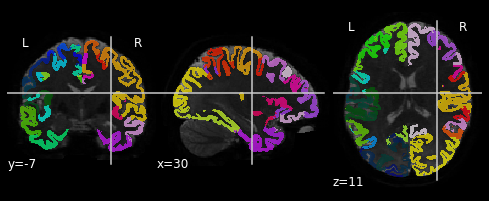

In [24]:
from nilearn import plotting as nplot


nplot.plot_roi(annot_img, dwi_img.slicer[:, :, :, 0])


In [30]:
np.unique(annot_img.get_data())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
shm.CsaOdfModel()

In [22]:
%%time

# takes approx. 7 mins to run 

# Here, csa = consant solid angle. 
# We are giving diffusion data which is an image with 288 different diffusion directions...
# This is a 4D image where the 4th dimension is the diffusion direction
# Each voxel has the "sphere" of directions" as seen above.
# At every voxel, you fit a model to the diffusion data (directionally sampled diffusion weighting measurement) and that model
# is basically a shape 
# Diffusion tensor model is an ellipsoid. Fit the shape of this model to the data. 
# Uses spherical harmonics. 
# a bit like how pca works. 

# The lines of code below have been borrowed from ...
# http://localhost:8891/notebooks/Code/shreysurf/scratch/tractography_basics.ipynb
# From cell #3 onwards ...


csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=dwi_dat,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=nbm_dat.astype(bool))

# csa peaks - a model at every voxel of the geometric shape of the water diffusion pattern. 
# Model of the diffusion orientation pattern.

CPU times: user 6min 30s, sys: 22.5 s, total: 6min 52s
Wall time: 6min 52s


In [23]:
#base_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/simnibs/testing/run_ernie_tutorial_v3/fsavg_overlays/'
in_file = '/nethome/kcni/hharita/Code/shreysurf/scratch/SimNIBS_to_FuncConn_F3_test_dlPFC_v2/fsavg_overlays/lh.ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm'

res0,res1,outfile = convert_simnibs_fsavg_to_cifti_32K(in_file,run_it=True)#False)#,base_dir=base_dir)



converting input file to .gii

mri_convert /nethome/kcni/hharita/Code/shreysurf/scratch/SimNIBS_to_FuncConn_F3_test_dlPFC_v2/fsavg_overlays/lh.ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm /nethome/kcni/hharita/Code/shreysurf/scratch/SimNIBS_to_FuncConn_F3_test_dlPFC_v2/fsavg_overlays/lh.ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm_164k.gii


converting .gii file to cifti 32k space

wb_command -metric-resample /nethome/kcni/hharita/Code/shreysurf/scratch/SimNIBS_to_FuncConn_F3_test_dlPFC_v2/fsavg_overlays/lh.ernie_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm_164k.gii /nethome/kcni/hharita/Code/HCPpipelines/global/templates/standard_mesh_atlases/resample_fsaverage/fsaverage_std_sphere.L.164k_fsavg_L.surf.gii /nethome/kcni/hharita/Code/HCPpipelines/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii ADAP_BARY_AREA /nethome/kcni/hharita/Code/shreysurf/scratch/SimNIBS_to_FuncConn_F3_test_dlPF

In [24]:
gii_img = nib.load(outfile)

In [25]:
gii_dat = gii_img.darrays[0].data[:]

In [85]:
gii_dat

array([0.05784884, 0.15604629, 0.37579626, ..., 0.17645913, 0.17885755,
       0.16834968], dtype=float32)

In [26]:
# disp = plot_surf_stat_map([pial_vtx,pial_tri], gii_dat, hemi='left', view='lateral', cmap='hot', 
#                           bg_map=None);

In [40]:
gii_dat_thr0p6_bin = (gii_dat>0.5).astype(float)

In [41]:
gii_patch_val = 1.
gii_patch_idx = np.nonzero(gii_dat_thr0p6_bin==gii_patch_val)[0]
gii_patch_idx.shape
# essentially, you're defining the patch region you want to create. 


(1913,)

In [93]:
lhwrhw32k_vtx

array([[ -5.9043903, -38.569595 ,  22.791294 ],
       [-14.198056 , -35.937576 ,  63.044044 ],
       [-47.507023 ,  -4.938016 ,  38.584553 ],
       ...,
       [ 58.350616 , -36.73624  ,  -9.005781 ],
       [ 59.845013 , -35.893356 ,  -8.383142 ],
       [ 59.268936 , -37.8942   ,  -7.976392 ]], dtype=float32)

In [94]:
lhwrhw32k_vtx[:,1]

array([-38.569595, -35.937576,  -4.938016, ..., -36.73624 , -35.893356,
       -37.8942  ], dtype=float32)

In [92]:
lhwrhw32k_vtx[...,1]

array([-38.569595, -35.937576,  -4.938016, ..., -36.73624 , -35.893356,
       -37.8942  ], dtype=float32)

In [89]:
aff

array([[  -1.25,    0.  ,    0.  ,   90.  ],
       [   0.  ,    1.25,    0.  , -126.  ],
       [   0.  ,    0.  ,    1.25,  -72.  ],
       [   0.  ,    0.  ,    0.  ,    1.  ]])

In [97]:
coords_ref_lh.shape

(32492, 3)

In [51]:
# a set of coords in the *_nii_dat file will correspond to a single label from the schaefer/yeo dat files at specified indices

coords_ref = np.zeros((len(lhwrhw32k_vtx[...,0]),3),dtype='float64')
aff = np.linalg.inv(nbm_img.affine)
coords_ref[:,0] = aff[0,0]*lhwrhw32k_vtx[...,0] + aff[0,1]*lhwrhw32k_vtx[...,1] + aff[0,2]* lhwrhw32k_vtx[...,2] + aff[0,3] 
coords_ref[:,1] = aff[1,0]*lhwrhw32k_vtx[...,0] + aff[1,1]*lhwrhw32k_vtx[...,1] + aff[1,2]* lhwrhw32k_vtx[...,2] + aff[1,3] 
coords_ref[:,2] = aff[2,0]*lhwrhw32k_vtx[...,0] + aff[2,1]*lhwrhw32k_vtx[...,1] + aff[2,2]* lhwrhw32k_vtx[...,2] + aff[2,3] 

coords_ref_lh = coords_ref[0:mt_vtx.shape[0]]

# Make a nifti image from the concatenated LH-RH 32K file >>> with schaefer 1000 parcellation labels <<<
lhwrhw32k_SimNIBS_gii_dat = np.zeros_like(nbm_dat)
for c_it,c in enumerate(coords_ref_lh):
    lhwrhw32k_SimNIBS_gii_dat[(c[0].astype(int), c[1].astype(int), c[2].astype(int))] = gii_dat[c_it]
lhwrhw32k_SimNIBS_gii_img = nib.Nifti1Image(lhwrhw32k_sch1000lab_nii_dat,nbm_img.affine)

In [52]:
dlPFC_dat = (lhwrhw32k_SimNIBS_gii_dat >= 0.5).astype(float)

In [86]:
lhwrhw32k_SimNIBS_gii_dat

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [98]:
nbm_img.shape

(145, 174, 145)

In [82]:
dlPFC_dat.shape

(145, 174, 145)

In [53]:
%%time

aff = b0_img.affine
seeds_d2_dlPFC = utils.seeds_from_mask(dlPFC_dat,aff,density=4) # <-- Density has been increased! Takes way longer to run!
stopping_criterion = BinaryStoppingCriterion(nbm_dat)

streamline_generator_b0aff_d2_dlPFC = LocalTracking(csapeaks,stopping_criterion,seeds_d2_dlPFC,affine=aff,step_size=0.5)
streamlines_b0aff_d2_dlPFC = Streamlines(streamline_generator_b0aff_d2_dlPFC)
streamlines_b0aff_d2_ds_dlPFC = np.array([approx_polygon_track(s) for s in streamlines_b0aff_d2_dlPFC])

# pull out a subset of streamlines you wish to work with ... as a representative group of the whole brain. 
subset_idx = np.arange(0,len(streamlines_b0aff_d2_ds_dlPFC),20)
streamlines_b0ff_d2_ds_dlPFC_subset = streamlines_b0aff_d2_ds_dlPFC[subset_idx]

# look into dipy.io
# to reduce runtime, seed only from ROIs of interest ... change lhwrhw32k to dlpfclhrh32k.
# make a different vertex array. 

CPU times: user 57.4 s, sys: 9.98 s, total: 1min 7s
Wall time: 1min 7s


In [105]:
streamlines_b0aff_d2_dlPFC

ArraySequence([array([[ 5.83956564, 41.98188688, 30.83350139],
       [ 5.34057419, 41.98066791, 30.80178323],
       [ 4.84169414, 41.98275351, 30.7684013 ],
       [ 4.34307714, 41.99105457, 30.73217732],
       [ 3.84494552, 42.00349669, 30.69082418],
       [ 3.34609598, 42.02541927, 30.66496816],
       [ 2.84725601, 42.05910516, 30.66007436],
       [ 2.34931909, 42.09597158, 30.68652594],
       [ 1.85606972, 42.11738294, 30.76556147],
       [ 1.3710937 , 42.12431795, 30.88701175],
       [ 0.88343507, 42.0868711 , 30.99087123],
       [ 0.39428534, 42.00727482, 31.05718087],
       [-0.0964044 , 41.91641053, 31.08828174],
       [-0.59474971, 41.90563654, 31.12747189],
       [-1.08608901, 41.98050732, 31.18206184],
       [-1.56922911, 42.09400223, 31.24284462],
       [-2.03125   , 42.28125   , 31.28125   ],
       [-2.50432548, 42.43634805, 31.32755538],
       [-2.9612058 , 42.63875471, 31.34464083],
       [-3.40748279, 42.85899526, 31.39292072],
       [-3.83952513, 43.0

In [106]:
streamlines_b0aff_d2_ds_dlPFC

array([array([[ 5.8395658, 41.981888 , 30.833502 ],
       [ 1.3710938, 42.124317 , 30.887012 ],
       [-0.5947497, 41.905636 , 31.127472 ],
       [-2.5043254, 42.436348 , 31.327555 ],
       [-4.2495036, 43.353004 , 31.60485  ]], dtype=float32),
       array([[ 5.5011086, 41.71704  , 30.859533 ],
       [ 1.0374035, 41.89915  , 31.03964  ],
       [-0.9445553, 41.779766 , 31.16668  ],
       [-2.8090715, 42.46157  , 31.312243 ],
       [-4.1211586, 43.141216 , 31.544455 ]], dtype=float32),
       array([[ 5.638492 , 41.409313 , 30.924578 ],
       [ 1.180723 , 41.66472  , 31.096212 ],
       [-0.809924 , 41.565895 , 31.155315 ],
       [-2.65625  , 42.28125  , 31.28125  ],
       [-4.4000325, 43.189594 , 31.601753 ]], dtype=float32),
       ...,
       array([[-58.52062   ,   5.145117  ,  10.666691  ],
       [-58.14428   ,   3.0098789 ,  14.015511  ],
       [-58.082348  ,   1.9297502 ,  15.689596  ],
       [-57.57701   ,   0.38827348,  17.5855    ]], dtype=float32),
       array(

CPU times: user 16.2 s, sys: 432 ms, total: 16.6 s
Wall time: 16.6 s


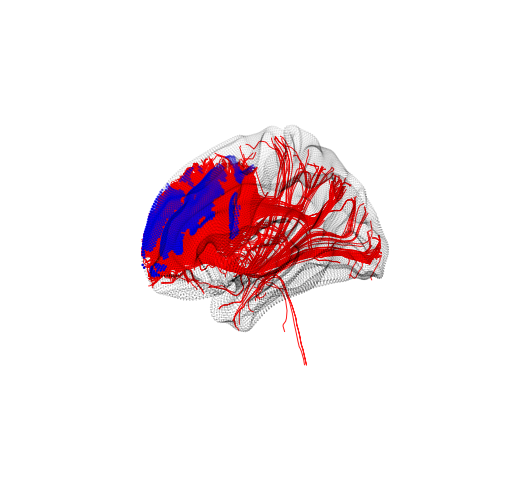

In [54]:
%%time

fig, ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(9,9))
for s in streamlines_b0ff_d2_ds_dlPFC_subset:
    x,y,z = s.T
    ax.plot(y,z,c='r',linewidth=1,alpha=0.9)
df_mt_vtx.plot(kind='scatter', x='y', y='z', ax=ax,s=0.05,marker='.',c='k')
df_mt_vtx.iloc[gii_patch_idx,:].plot(kind='scatter', x='y', y='z', ax=ax, s=10,marker='.',c='b')
ax.axis('off')
ax.view_init(azim=90,elev=-95)

# plt.title("Subject {0}, ID - {1}".format((i+1),sub_list[i]), fontsize=10)

In [55]:
Connectivity_Matrix_gii, grouping_gii = utils.connectivity_matrix(streamlines_b0aff_d2_ds_dlPFC,
                                                              b0_img.affine,
                                                              lhwrhw32k_SimNIBS_gii_dat.astype(int),
                                                              return_mapping=True,
                                                              mapping_as_streamlines=True)


Connectivity_Matrix_sch1000, grouping_sch1000 = utils.connectivity_matrix(streamlines_b0aff_d2_ds_dlPFC,
                                                              b0_img.affine,
                                                              lhwrhw32k_sch1000lab_nii_dat.astype(int),
                                                              return_mapping=True,
                                                              mapping_as_streamlines=True)

In [71]:
#  Specify the path to the .annot file
annot_file = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/PyTepFit/Data/fs_directory/100307/mri/100307_Schaefer2018_400Parcels_7Networks_rewritten.nii.gz'

# Load the .annot file
annot_img = nib.load(annot_file)

# Access the data from the .annot file
annot_data = annot_img.get_data()

In [79]:
streamlines_b0ff_d2_ds_dlPFC_subset[0]

array([[ 5.8395658, 41.981888 , 30.833502 ],
       [ 1.3710938, 42.124317 , 30.887012 ],
       [-0.5947497, 41.905636 , 31.127472 ],
       [-2.5043254, 42.436348 , 31.327555 ],
       [-4.2495036, 43.353004 , 31.60485  ]], dtype=float32)

In [72]:
Connectivity_Matrix_sch1000, grouping_sch1000 = utils.connectivity_matrix(streamlines_b0ff_d2_ds_dlPFC_subset,
                                                              b0_img.affine,
                                                              annot_data,
                                                              return_mapping=True,
                                                              mapping_as_streamlines=True)

In [73]:
Connectivity_Matrix_sch1000 = Connectivity_Matrix_sch1000[1:,1:]


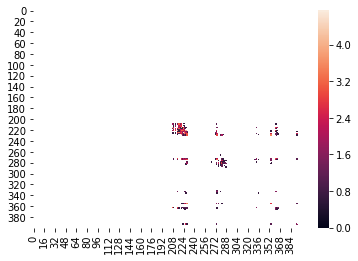

In [111]:
sns.heatmap(np.log1p(Connectivity_Matrix_sch1000),mask=Connectivity_Matrix_sch1000==0)

In [56]:
Connectivity_Matrix_gii = Connectivity_Matrix_gii[1:,1:]

Connectivity_Matrix_sch1000 = Connectivity_Matrix_sch1000[1:,1:]


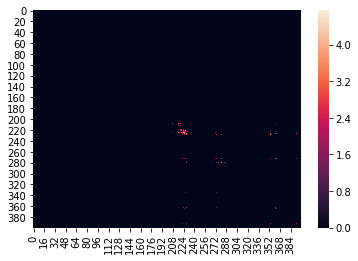

In [109]:
sns.heatmap(np.log1p(Connectivity_Matrix_sch1000))

In [58]:
lh_sch1000_parc_v2 = sch1000_parc[0:32492]

CPU times: user 909 ms, sys: 74.9 ms, total: 984 ms
Wall time: 987 ms


Text(0.5, 1.0, 'Str Conn')

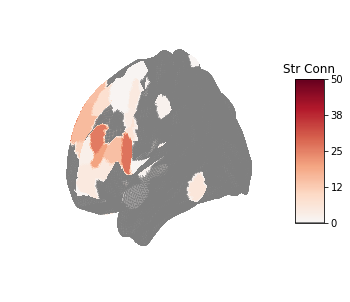

In [59]:
%%time
sc_col = Connectivity_Matrix_sch1000[:,:].sum(axis=1)
lh_sc_col_on_surf = np.zeros_like(mt_vtx[:,0]) # this 32k 
for p_it in range(0,400):
    these_vtcs = lh_sch1000_parc_v2==p_it # but this is 29k
    lh_sc_col_on_surf[these_vtcs] = sc_col[p_it]
disp = plot_surf_stat_map([mt_vtx,mt_tri], lh_sc_col_on_surf,cmap='RdBu_r',hemi='left',view='lateral',vmax=50, threshold = 1)
plt.title('Str Conn', loc = 'center')

CPU times: user 857 ms, sys: 86.9 ms, total: 944 ms
Wall time: 941 ms


Text(0.5, 1.0, 'Str Conn')

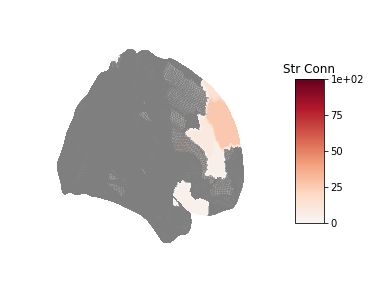

In [60]:
%%time
sc_col = Connectivity_Matrix_sch1000[:,:].sum(axis=1)
lh_sc_col_on_surf = np.zeros_like(mt_vtx[:,0]) # this 32k 
for p_it in range(0,400):
    these_vtcs = lh_sch1000_parc_v2==p_it # but this is 29k
    lh_sc_col_on_surf[these_vtcs] = sc_col[p_it]
disp = plot_surf_stat_map([mt_vtx,mt_tri], lh_sc_col_on_surf,cmap='RdBu_r',hemi='left',view='medial',vmax=100, threshold = 1)
plt.title('Str Conn', loc = 'center')

## Graveyard

In [31]:
import numpy as np
from scipy.ndimage.morphology import binary_dilation

from dipy.data import read_stanford_labels, read_stanford_t1
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines

hardi_img, gtab, labels_img = read_stanford_labels()
data = hardi_img.get_data()
labels = labels_img.get_data()

In [32]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86,
       87, 88], dtype=uint8)

In [33]:
labels.shape

(81, 106, 76)

In [38]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86,
       87, 88], dtype=uint8)